In [ ]:
# https://tinyurl.com/cbk-2019-tic-tac-toe

In [1]:
import sys
sys.path.append('C:\Program Files\Python37\lib\site-packages')

import pygame
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(3*3, 50)
        self.fc2 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [133]:
class tic_tac_toe:
    def __init__(self):
        self.board = [[' ' for y in range(3)] for x in range(3)]
        self.winReward = -3.0
        self.tieReward = 3.0
        self.lossReward = 0.0
        
    def getMoves(self):
        moves = []
        for x in range(3):
            for y in range(3):
                if self.board[x][y] == ' ':
                    moves.append((x, y))
        return moves
    
    def makeMove(self, loc, which):
        x, y = loc
        self.board[x][y] = which
        
        if self.board[0][y] == self.board[1][y] == self.board[2][y]:
            return True, torch.FloatTensor([self.winReward]).unsqueeze(0)
        
        if self.board[x][0] == self.board[x][1] == self.board[x][2]:
            return True, torch.FloatTensor([self.winReward]).unsqueeze(0)
        
        if x == y and self.board[0][0] == self.board[1][1] == self.board[2][2]:
            return True, torch.FloatTensor([self.winReward]).unsqueeze(0)
        
        if x + y == 2 and self.board[0][2] == self.board[1][1] == self.board[2][0]:
            return True, torch.FloatTensor([self.winReward]).unsqueeze(0)
        
        isTie = True
        for x in range(3):
            for y in range(3):
                if self.board[x][y] == ' ':
                    isTie = False
        if isTie:
            return isTie, torch.FloatTensor([self.tieReward]).unsqueeze(0)
        else:
            return isTie, torch.FloatTensor([self.lossReward]).unsqueeze(0)
        
    def undoMove(self, loc):
        x, y = loc
        self.board[x][y] = ' '
        
    def getBoard(self):
        board = [[0 for y in range(3)] for x in range(3)]
        for x in range(3):
            for y in range(3):
                if self.board[x][y] == 'x':
                    board[x][y] = 1
                elif self.board[x][y] == 'o':
                    board[x][y] = -1
                
        return torch.FloatTensor(board).unsqueeze(0)
        

In [134]:
def epsilonGreedy(Qnet, game, epsilon):
    moves = game.getMoves()
    if np.random.uniform() < epsilon:
        move = moves[random.sample(range(len(moves)), 1)[0]]
        game.makeMove(move, 'x')
        Q = Qnet(game.getBoard())
        game.undoMove(move)
    # greedy move
    else:
        qs = []
        for move in moves:
            game.makeMove(move, 'x')
            qs.append(Qnet(game.getBoard()))
            game.undoMove(move)
        move = moves[np.argmax(qs)]
        Q = np.max(qs)
    return move, Q

In [135]:
def randomMover(game):
    return random.choice(game.getMoves())

In [136]:
def networkMover(game):
    qs = []
    moves = game.getMoves()
    for move in moves:
        game.makeMove(move, 'o')
        qs.append(network(-game.getBoard()))
        game.undoMove(move)
    move = moves[np.argmax(qs)]
    Q = np.max(qs)
    
    return move

In [137]:
def trainQnet(Qnet, optim, lossFunc, nReps, nIterations, epsilon, epsilonDecayFactor, game, opponentStrategyF):
    outcomes = np.zeros(nReps)
    quickWinRatio = np.zeros(nReps)
    quickTieRatio = np.zeros(nReps)

    for rep in range(nReps):
        if rep > 0:
            if epsilon >= 0.01:
                epsilon -= epsilonDecayFactor
        step = 0
        done = False
        
        game.__init__()
        
        states = torch.tensor([])
        Qs = torch.tensor([])
        
        # Pick our initial move
        move, Qnext = epsilonGreedy(Qnet, game, epsilon)
        while not done:
            
            # Neural network makes move
            done, Qgame = game.makeMove(move, 'x')
            
            # Opponent makes move
            if not done:
                muv = opponentStrategyF(game)
                done, Qgame = game.makeMove(muv, 'o')
                Qgame = -Qgame
                
            if not done:
                # Figure out how we should next move and what the new score is
                move, Qnext = epsilonGreedy(Qnet, game, epsilon)
                Qgame = torch.clamp(Qnext + Qgame, -1, 1)
            else:
                # Record and print this outcome
                outcomes[rep] = Qgame
                print('Repetition:', rep, "Epsilon:", epsilon)
                print(game.board)
                print("Win ratio:", sum(outcomes == game.winReward)/(rep+1))
                back = rep - 49 if rep > 49 else 0
                bot = 50 if rep > 49 else rep + 1
                quickWinRatio[rep] = sum(outcomes[back:rep+1] == game.winReward)/bot
                print("Win ratio past 50:", quickWinRatio[rep])
                quickTieRatio[rep] = sum(outcomes[back:rep+1] == game.tieReward)/bot
                print("Tie ratio past 50:", quickTieRatio[rep])
                print()
               
            # Store the states and Qs so we can train at end
            board = game.getBoard()
            states = torch.cat((states, board), dim=0)
            Qs = torch.cat((Qs, Qgame), dim=0)
            
        for i in range(nIterations):
            optim.zero_grad()
            out = network(states)
            loss = lossFunc(out, Qs)
            loss.backward(retain_graph=True)
            optimizer.step()
        # save here

    print('DONE')
    return Qnet, outcomes, quickWinRatio, quickTieRatio

In [138]:
network = NeuralNetwork()
optimizer = optim.SGD(network.parameters(), lr=0.005)
loss = nn.MSELoss()

nReps = 1000
nIterations = 1
epsilon = 1
epsilonDecayFactor = 0.01

strat = randomMover

game = tic_tac_toe()

Qnet, outcomes, quickWinRatio, quickTieRatio = trainQnet(network, optimizer, loss, nReps, nIterations, epsilon, epsilonDecayFactor, game, strat)

Repetition: 0 Epsilon: 1
[['o', ' ', 'o'], ['o', 'x', 'x'], ['o', 'x', 'x']]
Win ratio: 0.0
Win ratio past 50: 0.0
Tie ratio past 50: 1.0

Repetition: 1 Epsilon: 0.99
[['x', 'x', 'x'], [' ', ' ', 'o'], [' ', ' ', 'o']]
Win ratio: 0.5
Win ratio past 50: 0.5
Tie ratio past 50: 0.5

Repetition: 2 Epsilon: 0.98
[['x', 'x', 'o'], ['o', 'x', 'x'], ['x', 'o', 'o']]
Win ratio: 0.3333333333333333
Win ratio past 50: 0.3333333333333333
Tie ratio past 50: 0.6666666666666666

Repetition: 3 Epsilon: 0.97
[['x', 'o', 'x'], ['x', 'o', 'o'], ['o', 'x', 'x']]
Win ratio: 0.25
Win ratio past 50: 0.25
Tie ratio past 50: 0.75

Repetition: 4 Epsilon: 0.96
[['x', ' ', 'x'], ['o', 'x', 'o'], ['o', ' ', 'x']]
Win ratio: 0.4
Win ratio past 50: 0.4
Tie ratio past 50: 0.6

Repetition: 5 Epsilon: 0.95
[['x', 'x', 'o'], [' ', 'o', 'o'], ['x', 'x', 'o']]
Win ratio: 0.3333333333333333
Win ratio past 50: 0.3333333333333333
Tie ratio past 50: 0.6666666666666666

Repetition: 6 Epsilon: 0.94
[['o', 'x', 'x'], ['x', 'o', '

Win ratio past 50: 0.5454545454545454
Tie ratio past 50: 0.45454545454545453

Repetition: 44 Epsilon: 0.5599999999999996
[['o', 'x', 'o'], ['x', 'x', 'x'], ['o', 'o', 'x']]
Win ratio: 0.5555555555555556
Win ratio past 50: 0.5555555555555556
Tie ratio past 50: 0.4444444444444444

Repetition: 45 Epsilon: 0.5499999999999996
[['x', 'x', 'o'], ['o', 'o', ' '], ['o', 'x', 'x']]
Win ratio: 0.5434782608695652
Win ratio past 50: 0.5434782608695652
Tie ratio past 50: 0.45652173913043476

Repetition: 46 Epsilon: 0.5399999999999996
[['o', 'x', 'x'], ['x', 'o', 'x'], ['o', 'o', 'x']]
Win ratio: 0.5531914893617021
Win ratio past 50: 0.5531914893617021
Tie ratio past 50: 0.44680851063829785

Repetition: 47 Epsilon: 0.5299999999999996
[[' ', ' ', 'x'], ['o', 'o', 'o'], [' ', 'x', 'x']]
Win ratio: 0.5416666666666666
Win ratio past 50: 0.5416666666666666
Tie ratio past 50: 0.4583333333333333

Repetition: 48 Epsilon: 0.5199999999999996
[['x', 'x', 'o'], ['o', 'o', 'x'], ['x', 'x', 'o']]
Win ratio: 0.5306

Tie ratio past 50: 0.48

Repetition: 90 Epsilon: 0.09999999999999924
[['x', 'x', 'x'], ['x', 'o', 'o'], ['o', 'x', 'o']]
Win ratio: 0.5384615384615384
Win ratio past 50: 0.54
Tie ratio past 50: 0.46

Repetition: 91 Epsilon: 0.08999999999999925
[['x', 'o', 'o'], ['x', 'x', 'x'], ['o', 'x', 'o']]
Win ratio: 0.5434782608695652
Win ratio past 50: 0.54
Tie ratio past 50: 0.46

Repetition: 92 Epsilon: 0.07999999999999925
[['o', 'o', 'o'], ['x', ' ', ' '], ['x', 'x', ' ']]
Win ratio: 0.5376344086021505
Win ratio past 50: 0.52
Tie ratio past 50: 0.48

Repetition: 93 Epsilon: 0.06999999999999926
[['x', 'o', 'o'], ['x', 'x', 'o'], ['o', 'x', 'x']]
Win ratio: 0.5425531914893617
Win ratio past 50: 0.54
Tie ratio past 50: 0.46

Repetition: 94 Epsilon: 0.059999999999999255
[['x', 'x', 'o'], [' ', 'o', 'o'], ['o', 'x', 'x']]
Win ratio: 0.5368421052631579
Win ratio past 50: 0.52
Tie ratio past 50: 0.48

Repetition: 95 Epsilon: 0.04999999999999925
[['x', 'x', 'o'], [' ', 'o', 'x'], ['o', 'x', 'o']]
Win

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Win ratio past 50: 0.24
Tie ratio past 50: 0.76

Repetition: 257 Epsilon: 0.009999999999999247
[['o', 'x', ' '], ['o', ' ', ' '], ['o', 'x', 'x']]
Win ratio: 0.3992248062015504
Win ratio past 50: 0.22
Tie ratio past 50: 0.78

Repetition: 258 Epsilon: 0.009999999999999247
[['x', 'x', 'x'], ['x', 'o', 'o'], ['o', 'x', 'o']]
Win ratio: 0.4015444015444015
Win ratio past 50: 0.24
Tie ratio past 50: 0.76

Repetition: 259 Epsilon: 0.009999999999999247
[['o', 'x', ' '], ['o', ' ', ' '], ['o', 'x', 'x']]
Win ratio: 0.4
Win ratio past 50: 0.24
Tie ratio past 50: 0.76

Repetition: 260 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['o', 'x', 'o'], ['o', 'x', 'x']]
Win ratio: 0.40229885057471265
Win ratio past 50: 0.24
Tie ratio past 50: 0.76

Repetition: 261 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['x', ' ', 'o'], ['o', 'x', 'o']]
Win ratio: 0.40076335877862596
Win ratio past 50: 0.24
Tie ratio past 50: 0.76

Repetition: 262 Epsilon: 0.009999999999999247
[['o', 'x', 'x'], ['x', 'o', ' ']

Repetition: 303 Epsilon: 0.009999999999999247
[['o', 'x', ' '], ['o', ' ', ' '], ['o', 'x', 'x']]
Win ratio: 0.375
Win ratio past 50: 0.22
Tie ratio past 50: 0.78

Repetition: 304 Epsilon: 0.009999999999999247
[['x', 'x', ' '], ['o', 'o', 'o'], ['x', 'x', 'o']]
Win ratio: 0.3737704918032787
Win ratio past 50: 0.22
Tie ratio past 50: 0.78

Repetition: 305 Epsilon: 0.009999999999999247
[['x', 'o', 'x'], ['x', 'o', 'o'], ['x', 'x', 'o']]
Win ratio: 0.3758169934640523
Win ratio past 50: 0.24
Tie ratio past 50: 0.76

Repetition: 306 Epsilon: 0.009999999999999247
[['o', 'x', 'o'], ['x', 'o', 'x'], [' ', 'x', 'o']]
Win ratio: 0.3745928338762215
Win ratio past 50: 0.24
Tie ratio past 50: 0.76

Repetition: 307 Epsilon: 0.009999999999999247
[['o', 'x', 'o'], ['x', 'x', 'o'], ['o', 'x', 'x']]
Win ratio: 0.37662337662337664
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 308 Epsilon: 0.009999999999999247
[['x', 'x', ' '], ['o', 'o', 'o'], [' ', 'x', ' ']]
Win ratio: 0.3754045307443365

[['x', 'x', ' '], ['o', 'o', 'o'], ['x', 'x', 'o']]
Win ratio: 0.36
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 350 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], [' ', 'o', 'o'], ['x', 'x', 'o']]
Win ratio: 0.358974358974359
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 351 Epsilon: 0.009999999999999247
[['x', 'x', ' '], ['o', 'o', 'o'], ['x', 'x', 'o']]
Win ratio: 0.35795454545454547
Win ratio past 50: 0.24
Tie ratio past 50: 0.76

Repetition: 352 Epsilon: 0.009999999999999247
[['o', 'x', 'o'], ['o', 'o', 'x'], ['x', 'x', 'x']]
Win ratio: 0.3597733711048159
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 353 Epsilon: 0.009999999999999247
[['x', 'x', 'x'], ['x', 'o', 'o'], ['o', 'x', 'o']]
Win ratio: 0.3615819209039548
Win ratio past 50: 0.28
Tie ratio past 50: 0.72

Repetition: 354 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['x', 'o', ' '], ['o', 'x', 'o']]
Win ratio: 0.36056338028169016
Win ratio past 50: 0.28
Tie ratio past 50: 0.7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.009999999999999247
[['x', 'x', 'o'], ['x', 'o', ' '], ['o', 'x', 'o']]
Win ratio: 0.34563106796116505
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 515 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], [' ', 'o', 'o'], ['o', 'x', 'x']]
Win ratio: 0.3449612403100775
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 516 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['o', 'o', 'o'], [' ', 'x', 'x']]
Win ratio: 0.344294003868472
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 517 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], [' ', ' ', 'o'], [' ', 'x', 'o']]
Win ratio: 0.3436293436293436
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 518 Epsilon: 0.009999999999999247
[['o', 'x', 'x'], ['x', 'x', 'o'], ['o', 'x', 'o']]
Win ratio: 0.3448940269749518
Win ratio past 50: 0.26
Tie ratio past 50: 0.74

Repetition: 519 Epsilon: 0.009999999999999247
[['o', 'x', 'o'], ['x', 'o', 'o'], ['x', 'x', 'x']]
Win ratio: 0.34615384615384615
Win ratio p

[['x', 'x', 'o'], [' ', ' ', 'o'], [' ', 'x', 'o']]
Win ratio: 0.34581105169340465
Win ratio past 50: 0.36
Tie ratio past 50: 0.64

Repetition: 561 Epsilon: 0.009999999999999247
[['x', 'x', 'x'], [' ', 'o', ' '], ['o', 'x', 'o']]
Win ratio: 0.3469750889679715
Win ratio past 50: 0.36
Tie ratio past 50: 0.64

Repetition: 562 Epsilon: 0.009999999999999247
[['o', 'x', 'x'], ['o', ' ', 'o'], ['o', 'x', 'x']]
Win ratio: 0.3463587921847247
Win ratio past 50: 0.34
Tie ratio past 50: 0.66

Repetition: 563 Epsilon: 0.009999999999999247
[['x', 'x', ' '], ['o', 'o', 'o'], [' ', 'x', ' ']]
Win ratio: 0.34574468085106386
Win ratio past 50: 0.34
Tie ratio past 50: 0.66

Repetition: 564 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], [' ', 'o', 'o'], ['x', 'x', 'o']]
Win ratio: 0.34513274336283184
Win ratio past 50: 0.34
Tie ratio past 50: 0.66

Repetition: 565 Epsilon: 0.009999999999999247
[['o', 'x', 'o'], [' ', 'o', 'x'], ['o', 'x', 'x']]
Win ratio: 0.34452296819787986
Win ratio past 50: 0.34
Tie r

Win ratio: 0.33607907742998355
Win ratio past 50: 0.22
Tie ratio past 50: 0.78

Repetition: 607 Epsilon: 0.009999999999999247
[['o', 'x', 'x'], ['o', 'o', ' '], ['o', 'x', 'x']]
Win ratio: 0.3355263157894737
Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 608 Epsilon: 0.009999999999999247
[['o', 'x', 'o'], [' ', 'o', 'x'], ['o', 'x', 'x']]
Win ratio: 0.33497536945812806
Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 609 Epsilon: 0.009999999999999247
[['o', 'x', 'x'], ['x', 'o', 'o'], ['o', 'x', 'x']]
Win ratio: 0.3344262295081967
Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 610 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], [' ', 'o', ' '], ['o', 'x', ' ']]
Win ratio: 0.33387888707037644
Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 611 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], [' ', 'o', 'o'], ['x', 'x', 'o']]
Win ratio: 0.3333333333333333
Win ratio past 50: 0.18
Tie ratio past 50: 0.82

Repetition: 612 Epsilon: 0.00999999999999

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 763 Epsilon: 0.009999999999999247
[['o', 'x', ' '], ['o', ' ', ' '], ['o', 'x', 'x']]
Win ratio: 0.31282722513089006
Win ratio past 50: 0.18
Tie ratio past 50: 0.82

Repetition: 764 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['o', 'o', 'o'], [' ', 'x', 'x']]
Win ratio: 0.31241830065359477
Win ratio past 50: 0.18
Tie ratio past 50: 0.82

Repetition: 765 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['o', 'o', 'x'], ['x', 'x', 'o']]
Win ratio: 0.31201044386422977
Win ratio past 50: 0.18
Tie ratio past 50: 0.82

Repetition: 766 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['o', 'o', 'x'], ['x', 'x', 'o']]
Win ratio: 0.3116036505867014
Win ratio past 50: 0.16
Tie ratio past 50: 0.84

Repetition: 767 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], [' ', 'o', 'o'], ['o', 'x', 'x']]
Win ratio: 0.3111979166666667
Win ratio past 50: 0.14
Tie ratio past 50: 0.86

Repetition: 768 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], 

Repetition: 809 Epsilon: 0.009999999999999247
[['o', 'x', 'x'], ['o', 'o', 'o'], [' ', 'x', 'x']]
Win ratio: 0.3074074074074074
Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 810 Epsilon: 0.009999999999999247
[['x', 'o', 'x'], ['x', 'o', 'o'], ['o', 'x', 'x']]
Win ratio: 0.3070283600493218
Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 811 Epsilon: 0.009999999999999247
[['o', 'x', 'o'], ['o', ' ', 'x'], ['o', 'x', 'x']]
Win ratio: 0.3066502463054187
Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 812 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['o', 'o', ' '], ['o', 'x', 'x']]
Win ratio: 0.3062730627306273
Win ratio past 50: 0.2
Tie ratio past 50: 0.8

Repetition: 813 Epsilon: 0.009999999999999247
[['x', 'x', 'x'], ['x', 'o', 'o'], ['o', 'x', 'o']]
Win ratio: 0.3071253071253071
Win ratio past 50: 0.22
Tie ratio past 50: 0.78

Repetition: 814 Epsilon: 0.009999999999999247
[['o', 'x', 'x'], ['o', 'o', ' '], ['o', 'x', 'x']]
Win ratio: 0.306748466257

[['x', 'x', 'o'], ['o', 'o', ' '], ['o', 'x', 'x']]
Win ratio: 0.29906542056074764
Win ratio past 50: 0.16
Tie ratio past 50: 0.84

Repetition: 856 Epsilon: 0.009999999999999247
[['o', 'x', 'x'], ['x', 'o', 'o'], ['o', 'x', 'x']]
Win ratio: 0.29871645274212366
Win ratio past 50: 0.14
Tie ratio past 50: 0.86

Repetition: 857 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['o', 'o', ' '], ['o', 'x', 'x']]
Win ratio: 0.29836829836829837
Win ratio past 50: 0.14
Tie ratio past 50: 0.86

Repetition: 858 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['o', ' ', 'o'], ['x', 'x', 'o']]
Win ratio: 0.2980209545983702
Win ratio past 50: 0.14
Tie ratio past 50: 0.86

Repetition: 859 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], ['x', ' ', 'o'], ['o', 'x', 'o']]
Win ratio: 0.29767441860465116
Win ratio past 50: 0.14
Tie ratio past 50: 0.86

Repetition: 860 Epsilon: 0.009999999999999247
[['x', 'x', 'o'], [' ', 'o', 'x'], ['o', 'x', 'o']]
Win ratio: 0.29732868757259
Win ratio past 50: 0.14
Tie rat

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



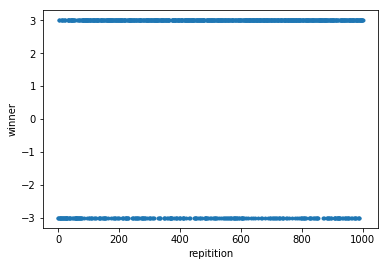

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(outcomes, '.')
ax.set_xlabel('repitition')
ax.set_ylabel('winner')
plt.show()

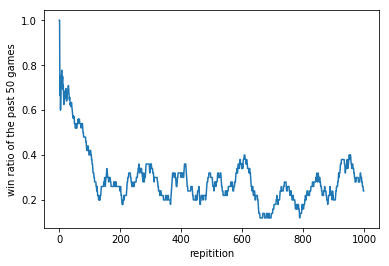

In [131]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(quickWinRatio)
ax.set_xlabel('repitition')
ax.set_ylabel('win ratio of the past 50 games')
plt.show()

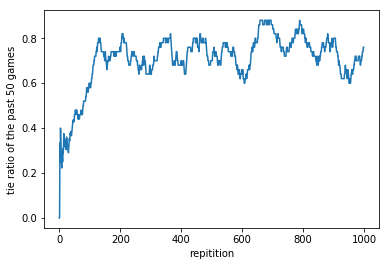

In [132]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(quickTieRatio)
ax.set_xlabel('repitition')
ax.set_ylabel('tie ratio of the past 50 games')
plt.show()

In [65]:
help(input)

Help on method raw_input in module ipykernel.kernelbase:

raw_input(prompt='') method of ipykernel.ipkernel.IPythonKernel instance
    Forward raw_input to frontends
    
    Raises
    ------
    StdinNotImplentedError if active frontend doesn't support stdin.



In [68]:
input(prompt='row?')
input(prompt='coloumn?')


row?1
coloumn?2


'2'